<a href="https://colab.research.google.com/github/gopalkalpande/20-Newsgroups/blob/master/data_preprocessing_for_flair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.externals import joblib
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/data/20 news group problem/"

20news-bydate-test		       test_tf_idf.joblib
20news-bydate-train		       train.csv
GoogleNews-vectors-negative300.bin     train_tf_idf.joblib
GoogleNews-vectors-negative300.bin.gz  xgb_clf.pickle.dat
test.csv


In [0]:
df = pd.read_csv('/content/drive/My Drive/data/20 news group problem/train.csv')
df1 = pd.read_csv('/content/drive/My Drive/data/20 news group problem/test.csv')


In [5]:
df.isna().any()

News         False
NewsGroup    False
dtype: bool

In [6]:
df1.isna().any()

News         False
NewsGroup    False
dtype: bool

In [7]:
df.shape, df1.shape

((11314, 2), (7532, 2))

In [8]:
news = df.News.values[0]
group = df.NewsGroup.values[0]
print(group)
print(news)

alt.atheism
From: mathew <mathew@mantis.co.uk>
Subject: Alt.Atheism FAQ: Atheist Resources
Summary: Books, addresses, music -- anything related to atheism
Keywords: FAQ, atheism, books, music, fiction, addresses, contacts
Expires: Thu, 29 Apr 1993 11:57:19 GMT
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Supersedes: <19930301143317@mantis.co.uk>
Lines: 290

Archive-name: atheism/resources
Alt-atheism-archive-name: resources
Last-modified: 11 December 1992
Version: 1.0

                              Atheist Resources

                      Addresses of Atheist Organizations

                                     USA

FREEDOM FROM RELIGION FOUNDATION

Darwin fish bumper stickers and assorted other atheist paraphernalia are
available from the Freedom From Religion Foundation in the US.

Write to:  FFRF, P.O. Box 750, Madison, WI 53701.
Telephone: (608) 256-8900

EVOLUTION DESIGNS

Evolution Designs sell the "Darwin fish".  It's a fish symbol, like the ones
Christian

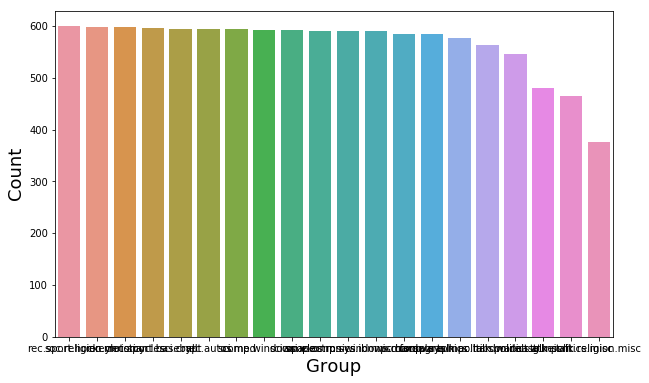

In [9]:
data_per_group = df.NewsGroup.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(data_per_group.index, data_per_group.values)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Group', fontsize=18);

In [10]:
print(data_per_group)

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: NewsGroup, dtype: int64


In [0]:
import re

def decontracted(phrase):
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_news = []
# tqdm is for printing the status bar
for news in tqdm(df.News):
    news = re.sub('<.*?>', '', news)
    news = re.sub(r"http\S+", "", news)
    news = BeautifulSoup(news, 'lxml').get_text()
    news = decontracted(news)
    news = re.sub("\S*\d\S*", "", news).strip()
    news = re.sub('[^A-Za-z]+', ' ', news)
    # https://gist.github.com/sebleier/554280
    news = ' '.join(e.lower() for e in news.split() if e.lower() not in stopwords)
    preprocessed_news.append(news.strip())

    
#print(preprocessed_reviews)

100%|██████████| 11314/11314 [00:08<00:00, 1359.89it/s]


In [14]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_news_test = []
# tqdm is for printing the status bar
for news in tqdm(df1.News):
    news = re.sub('<.*?>', '', news)
    news = re.sub(r"http\S+", "", news)
    news = BeautifulSoup(news, 'lxml').get_text()
    news = decontracted(news)
    news = re.sub("\S*\d\S*", "", news).strip()
    news = re.sub('[^A-Za-z]+', ' ', news)
    # https://gist.github.com/sebleier/554280
    news = ' '.join(e.lower() for e in news.split() if e.lower() not in stopwords)
    preprocessed_news_test.append(news.strip())

    
#print(preprocessed_reviews)

100%|██████████| 7532/7532 [00:04<00:00, 1515.44it/s]


In [0]:
y_train = df.NewsGroup
y_test = df1.NewsGroup

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [46]:
!pip install flair

     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 798kB 29.9MB/s 
     |████████████████████████████████| 1.0MB 49.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/70/55/6b/c12cf58209b8346f653a04f37dd8f607ab0e85a26238a23420
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Stored in directory: /root/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
Successfully built flair segtok mpld3 sqlitedict


In [47]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('Flair is pretty neat!')
classifier.predict(sentence)
# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2019-05-02 11:31:01,103 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/TEXT-CLASSIFICATION_imdb/imdb.pt not found in cache, downloading to /tmp/tmpez1svbrf


100%|██████████| 2794252905/2794252905 [01:00<00:00, 45838214.53B/s]

2019-05-02 11:32:02,256 copying /tmp/tmpez1svbrf to cache at /root/.flair/models/imdb.pt


2019-05-02 11:32:25,424 removing temp file /tmp/tmpez1svbrf
2019-05-02 11:32:25,447 loading file /root/.flair/models/imdb.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:542: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


Sentence above is:  [POSITIVE (1.0)]


In [50]:
df.head(1)

,News,NewsGroup
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism


In [99]:
df2 = pd.DataFrame(columns = ['label', 'text'])
df2.label = df.NewsGroup
df2.text = preprocessed_news
df2.head()

,label,text
0,alt.atheism,mathew subject alt atheism faq atheist resourc...
1,alt.atheism,subject must creator maybe halat pooh bears ji...
2,alt.atheism,subject americans evolution halat pooh bears j...
3,alt.atheism,keith cco caltech edu keith allan schneider su...
4,alt.atheism,keith cco caltech edu keith allan schneider su...


In [103]:
df3 = pd.DataFrame(columns = ['label', 'text'])
df3.label = df1.NewsGroup
df3.text = preprocessed_news_test
df3.head()


,label,text
0,alt.atheism,nanci ann miller subject amusing atheists agno...
1,alt.atheism,acooper mac cc macalstr edu turin turambar dep...
2,alt.atheism,mathew subject yet rushdie islamic law organiz...
3,alt.atheism,acooper mac cc macalstr edu turin turambar dep...
4,alt.atheism,jbrown batman bmd trw com subject gulf war sel...


In [102]:
preprocessed_news_test[0]

'nanci ann miller subject amusing atheists agnostics organization sponsored account school computer science carnegie mellon pittsburgh pa lines nntp posting host reply timmbake mcl ucsb edu bake timmons writes lies hypocrisy dude atheism takes much faith theism admit people might think takes faith atheist faith take kind faith say great invisible pink unicorn not exist take kind faith say santa claus not exist may people suppose certainly not big leap faith say things god exist suppose depends notion definition faith besides not believing god means one not deal extra baggage comes leaves person feeling wonderfully free especially beaten head years agree religion belief often important psychological healer many people reason think important however trying force psychological fantasy not mean bad way really someone else not interested extremely rude still believed santa claus said belief santa wonderful things life making better person allowing live without guilt etc tried get believe sa

In [0]:
df2['label'] = '__label__' + df2['label'].astype(str)
df3['label'] = '__label__' + df3['label'].astype(str)

In [0]:
df2.iloc[0:int(len(df2)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False, columns=['label', 'text'])
df2.iloc[int(len(df2)*0.8):].to_csv('dev.csv', sep='\t', index = False, header = False, columns=['label', 'text'])

In [0]:
df3.iloc[:].to_csv('test.csv', sep='\t', index = False, header = False, columns=['label', 'text'])

In [68]:
len(df2)

11314

In [106]:
df5 = pd.read_csv('test.csv')
len(df5)

7531

In [126]:
!ls

dev.csv       modeling.py	 sample_data	  training.log
drive	      optimization.py	 test.csv	  uncased_L-12_H-768_A-12.zip
loss.tsv      __pycache__	 tokenization.py  weights.txt
model_folder  run_classifier.py  train.csv


In [0]:
mv dev.csv '/content/drive/My Drive/data/20 news group problem/flair/'

In [0]:
from flair.data import TaggedCorpus
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

corpus = NLPTaskDataFetcher.load_corpus('train.csv')

In [120]:
#label_dict = corpus.make_label_dictionary()
corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), test_file='test.csv', dev_file='dev.csv', train_file='train.csv')



2019-05-02 12:33:02,533 Reading data from .
2019-05-02 12:33:02,536 Train: train.csv
2019-05-02 12:33:02,537 Dev: dev.csv
2019-05-02 12:33:02,540 Test: test.csv


In [121]:
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]

2019-05-02 12:33:45,787 this function is deprecated, use smart_open.open instead


In [122]:
document_embeddings = DocumentLSTMEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  """Entry point for launching an IPython kernel.


In [0]:
classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=True)

In [0]:
trainer = ModelTrainer(classifier, corpus)

In [125]:
trainer.train('./', max_epochs=10)

2019-05-02 12:34:00,122 ----------------------------------------------------------------------------------------------------
2019-05-02 12:34:00,124 Evaluation method: MICRO_F1_SCORE
2019-05-02 12:34:00,126 ----------------------------------------------------------------------------------------------------
2019-05-02 12:34:01,782 epoch 1 - iter 0/283 - loss 0.02179341


RuntimeError: ignored

In [114]:
print(corpus)
#print(corpus.obtain_statistics())


TaggedCorpus: 0 train + 0 dev + 0 test sentences
